# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* *Ethereum*
* *Bitcoin*
* *Dash*
* *XRP*

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [92]:
import DataExtractor

cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

extractionStartDate : str = "2018-01-01"
extractionEndDate : str = "2023-09-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, extractionStartDate, extractionEndDate, interval)

In [93]:
import os, pandas as pd

In [94]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

Per tenere conto dell'inflazione degli ultimi anni consideriamo una correzione sui prezzi fatta usando il Consumer Price Index, ottenuto estraendo i dati dal sito della FRED.
I dati estratti da quest'ultimo sito sono mensili, mentre i dati scaricati per le criptovalute sono periodici. Per rendere i dati omogenei procediamo facendo un'interpolazione lineare del CPI, ottenendo per ogni giorno il PCI.

In [95]:
cpiDataFrame = pd.read_csv(
    os.path.join("./", "data", "ConsumerPriceIndex.csv"),
    date_format = "%Y-%m-%d",
    parse_dates = ["DATE"]
    )
cpiDataFrame["DATE"] = pd.to_datetime(cpiDataFrame["DATE"])
cpiDataFrame

,DATE,CPIAUCSL
0,2017-12-01,247.805
1,2018-01-01,248.859
2,2018-02-01,249.529
3,2018-03-01,249.577
4,2018-04-01,250.227
...,...,...
65,2023-05-01,303.294
66,2023-06-01,303.841
67,2023-07-01,304.348
68,2023-08-01,306.269


In [96]:
import datetime
cpiInterpolatedDataFrame : pd.DataFrame = pd.DataFrame(columns = ["Date", "CPI"])

for i in range(0, cpiDataFrame.shape[0] - 1) :
    firstValue = cpiDataFrame.iloc[i]["CPIAUCSL"]
    secondValue = cpiDataFrame.iloc[i + 1]["CPIAUCSL"]
    valueDiff = secondValue - firstValue

    firstDate = cpiDataFrame.iloc[i]["DATE"]
    secondDate = cpiDataFrame.iloc[i + 1]["DATE"]
    dateDiff = secondDate - firstDate

    diffDays = dateDiff.days
    interValue = valueDiff / diffDays

    interpolatedValue = firstValue
    currDate = firstDate
    for dateIncr in range(1, diffDays + 1) :
        newRow = [currDate, interpolatedValue]
        cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = newRow

        interpolatedValue = interpolatedValue + interValue
        currDate = currDate + pd.Timedelta(days = 1)

lastDate = currDate
lastValue = interpolatedValue

cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = [lastDate, lastValue]
dateTimeStartDate = datetime.datetime.strptime(extractionStartDate, '%Y-%m-%d')
cpiFirstDate = dateTimeStartDate - datetime.timedelta(days = 1)
cpiInterpolatedDataFrame = cpiInterpolatedDataFrame[cpiInterpolatedDataFrame["Date"] >= datetime.datetime(year = cpiFirstDate.year, month = cpiFirstDate.month, day = cpiFirstDate.day)]
cpiInterpolatedDataFrame.reset_index(drop = True, inplace = True)
cpiInterpolatedDataFrame

,Date,CPI
0,2017-12-31,248.825000
1,2018-01-01,248.859000
2,2018-01-02,248.880613
3,2018-01-03,248.902226
4,2018-01-04,248.923839
...,...,...
2066,2023-08-28,307.324613
2067,2023-08-29,307.363710
2068,2023-08-30,307.402806
2069,2023-08-31,307.441903


In [97]:
cpiInterpolatedDataFrame["Infation"] = cpiInterpolatedDataFrame["CPI"].pct_change() * 100
cpiInterpolatedDataFrame.dropna(inplace = True)
cpiInterpolatedDataFrame.reset_index(inplace = True, drop = True)
cpiInterpolatedDataFrame

,Date,CPI,Infation
0,2018-01-01,248.859000,0.013664
1,2018-01-02,248.880613,0.008685
2,2018-01-03,248.902226,0.008684
3,2018-01-04,248.923839,0.008683
4,2018-01-05,248.945452,0.008683
...,...,...,...
2065,2023-08-28,307.324613,0.012723
2066,2023-08-29,307.363710,0.012722
2067,2023-08-30,307.402806,0.012720
2068,2023-08-31,307.441903,0.012718


In [98]:
## TODO Vedere bene come scontare i valori
for crypto in cryptoList :
    dataFrame : pd.DataFrame = cryptoDataFrameDict[crypto]
    dataFrame["NormalizedClose"] = dataFrame["Close"] * (1 - (cpiInterpolatedDataFrame["Infation"]))

cryptoDataFrameDict["ETH-USD"]

,Date,Open,High,Low,Close,Adj Close,Volume,NormalizedClose
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,762.083453
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,876.762752
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,954.359668
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,972.404366
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,989.057231
...,...,...,...,...,...,...,...,...
2065,2023-08-28,1657.439819,1659.328735,1627.446777,1652.457397,1652.457397,4855588534,1631.432731
2066,2023-08-29,1652.274170,1742.637329,1639.576172,1729.725708,1729.725708,11304916729,1707.720736
2067,2023-08-30,1729.676636,1730.564697,1697.147217,1705.112183,1705.112183,5023904190,1683.423095
2068,2023-08-31,1705.364502,1720.011963,1634.850952,1645.639160,1645.639160,6593153505,1624.709233


## 2. Analisi del Dataset

### 2_1. Passaggio al Logaritmo

In [99]:
import numpy as np

In [100]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [101]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "NormalizedClose")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.882003
1       2.942882
2       2.979712
3       2.987847
4       2.995221
          ...   
2065    3.212569
2066    3.232417
2067    3.226193
2068    3.210776
2069    3.206227
Name: LogClosePrice, Length: 2070, dtype: float64

In [102]:
import matplotlib.pyplot as plt

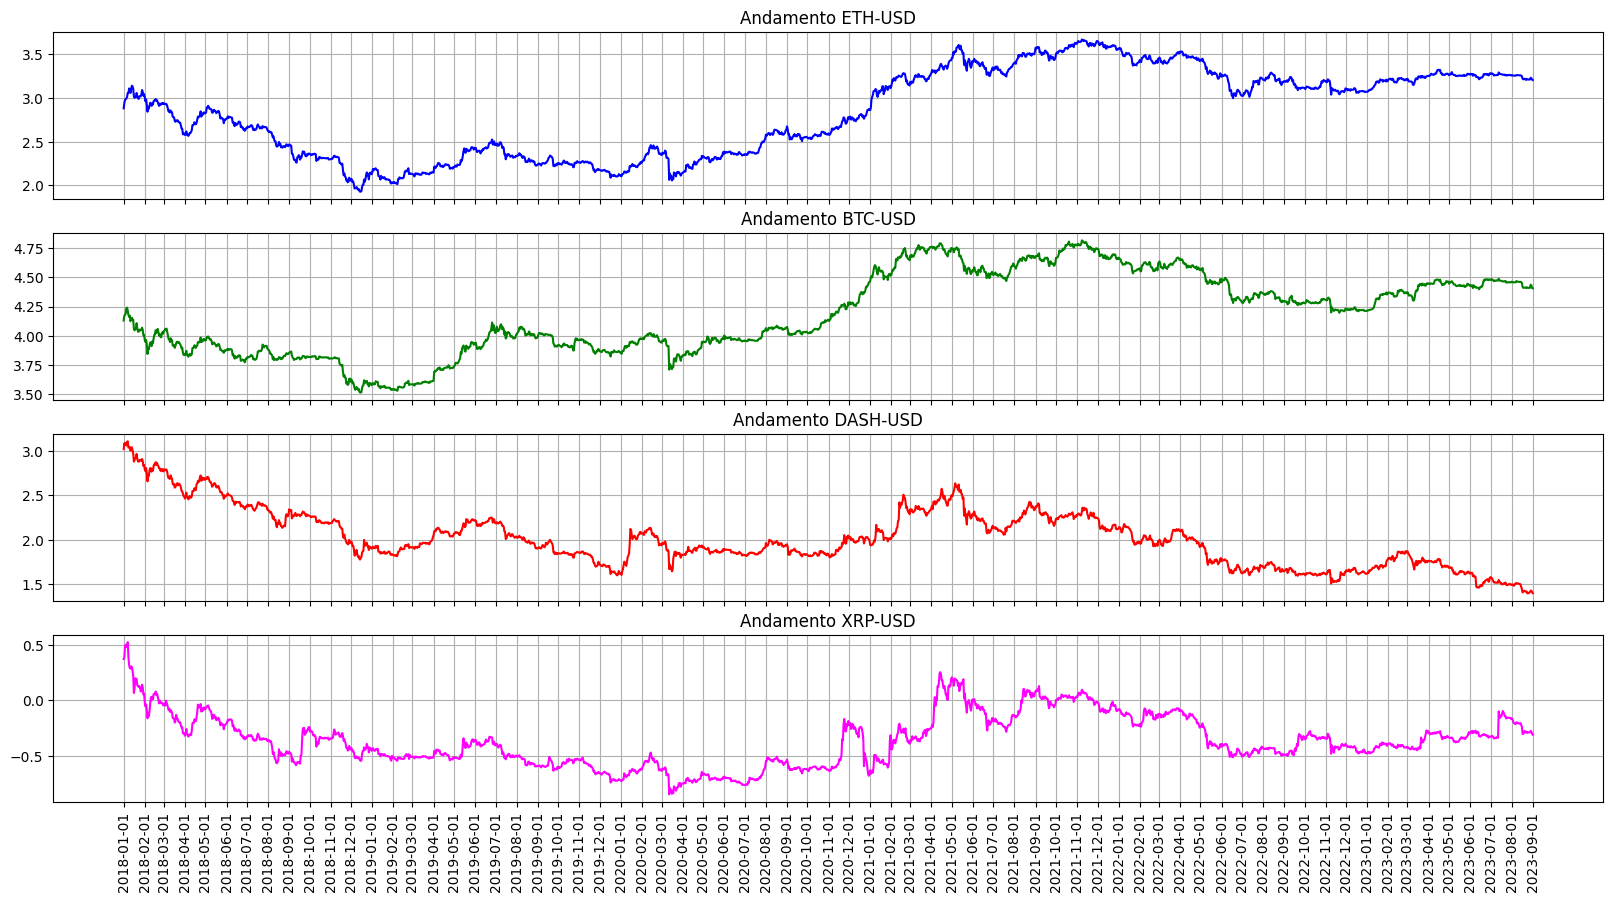

<Figure size 640x480 with 0 Axes>

In [133]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

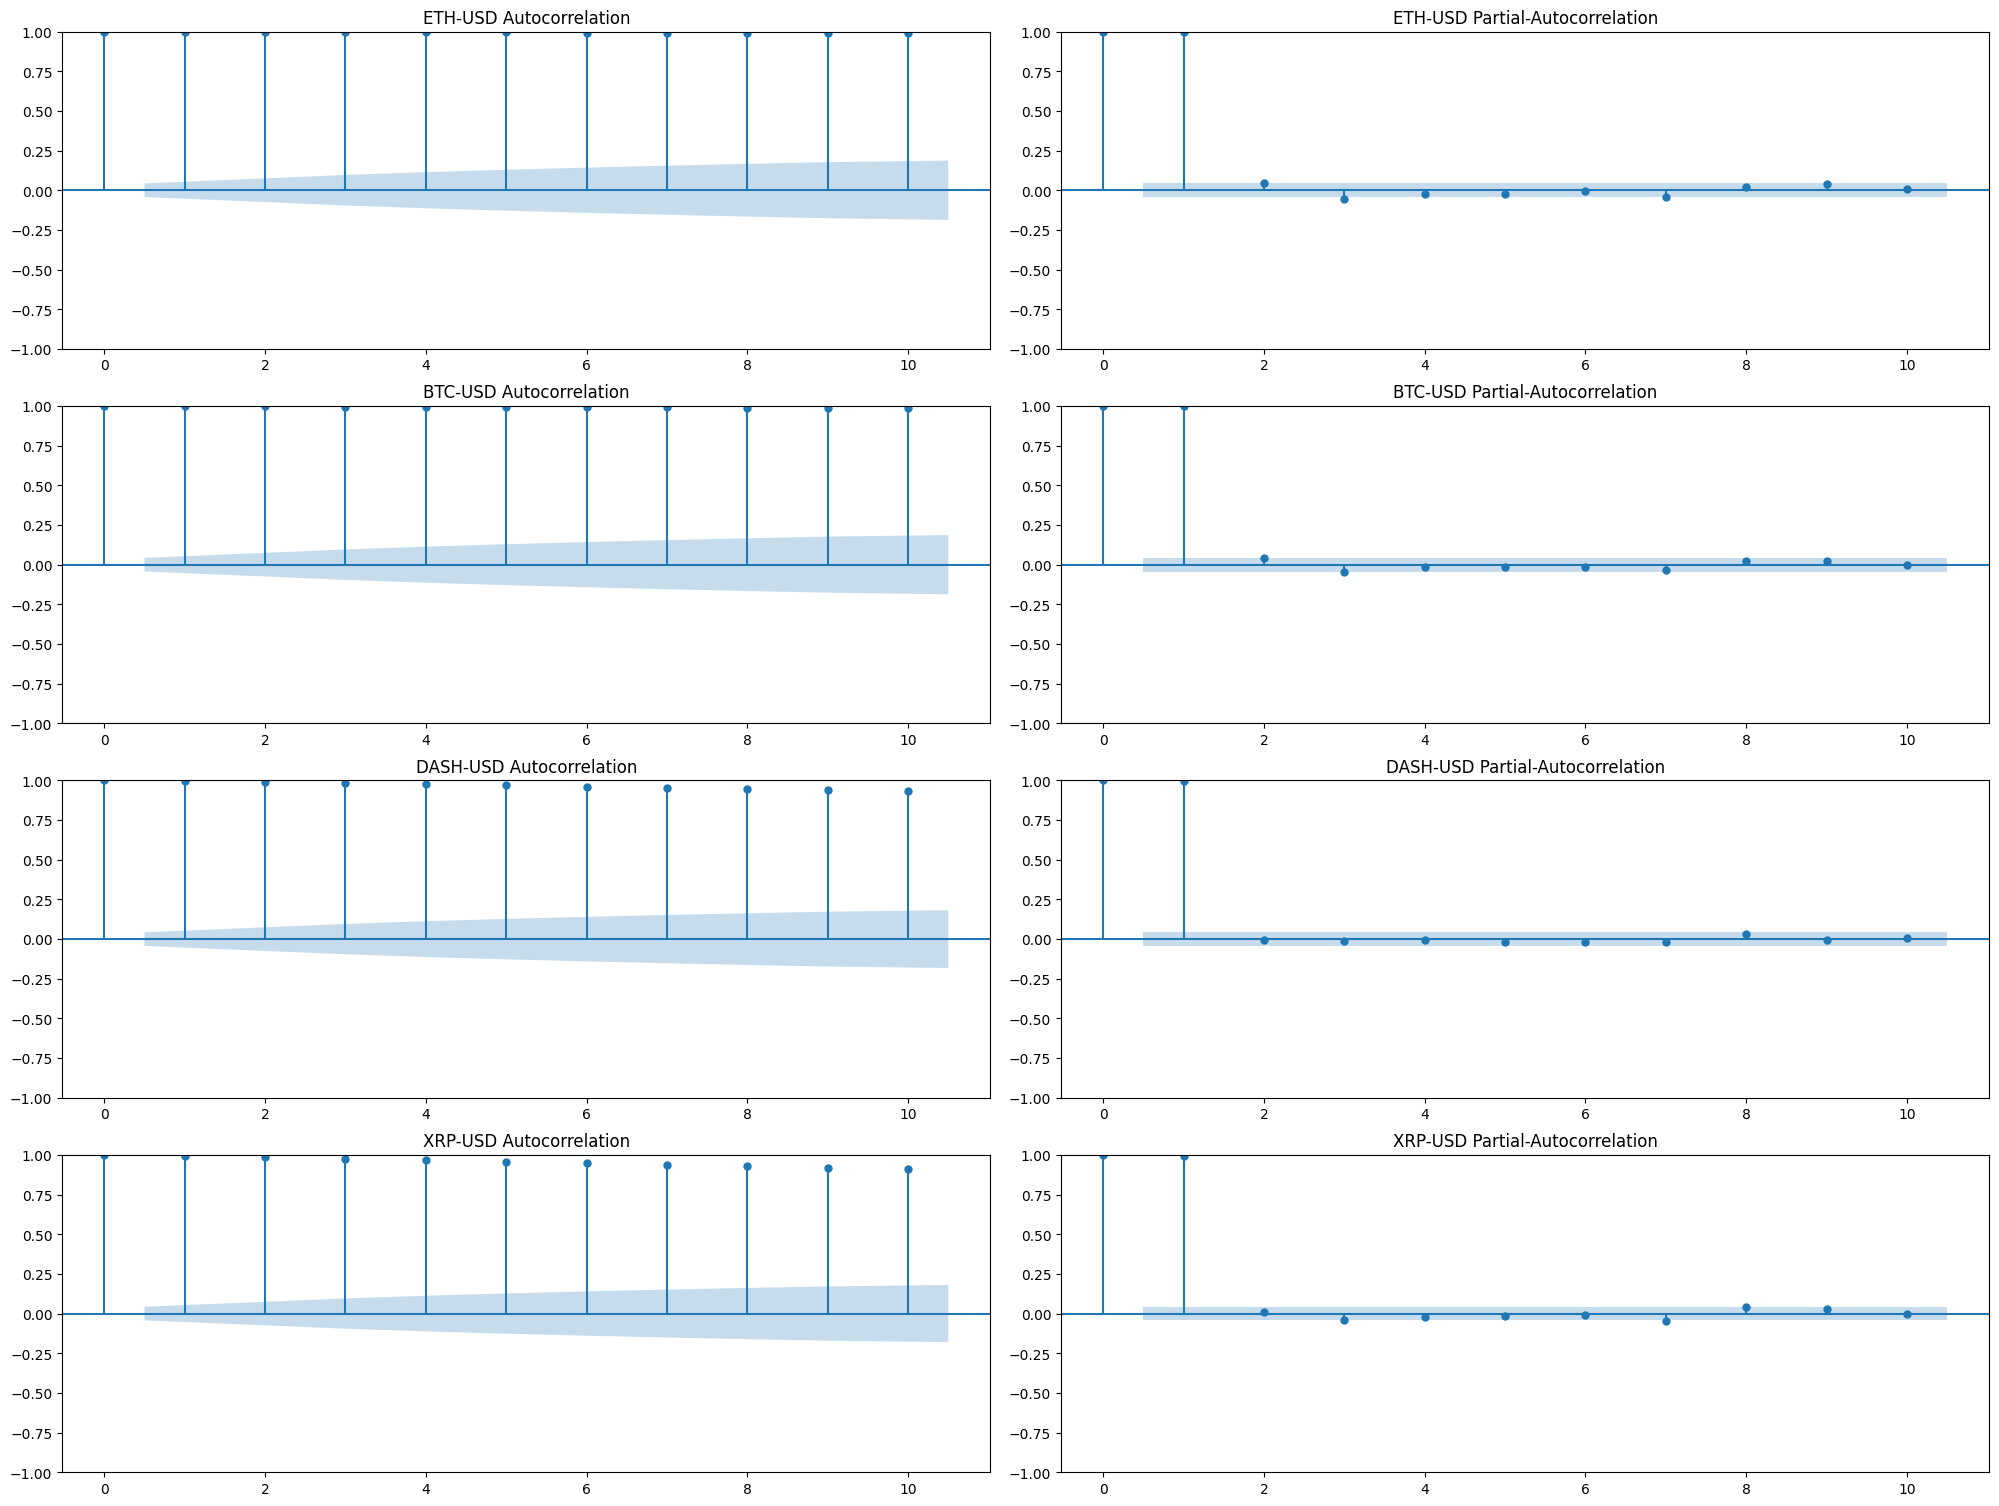

<Figure size 640x480 with 0 Axes>

In [104]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

N_LAGS = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
fig.tight_layout(h_pad = 2, w_pad =2)
i = 0 
for crypto in cryptoList :
    plot_acf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i][0], lags = N_LAGS, title = crypto + " Autocorrelation")
    i += 1

i = 0
for crypto in cryptoList :
    plot_pacf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i][1], lags = N_LAGS, title = crypto + " Partial-Autocorrelation")
    i += 1
plt.show()
plt.clf()

Usando i test di *Structural Break*, cerchiamo se ci sono dei punti all'interno della serie in cui i parametri del modello possano cambiare in modo significativo.

In [159]:
from statsmodels.tools.tools import add_constant
from statsmodels.api import OLS
from scipy import stats

dataFrame : pd.DataFrame = cryptoDataFrameDict["ETH-USD"]
breakPointBoolSeries = cryptoDataFrameDict["ETH-USD"]["Date"].str.endswith("01")
breakPoints = cryptoDataFrameDict[crypto][breakPointBoolSeries]
foundBreakPointList = []
for breakPointDate in breakPoints["Date"] :
    firstPeriod : pd.DataFrame = dataFrame[dataFrame["Date"] <= breakPointDate]
    secondPeriod : pd.DataFrame = dataFrame[dataFrame["Date"] > breakPointDate]

    # # Add a constant term to the data
    X = add_constant(dataFrame.index.astype(int))
    X1 = add_constant(firstPeriod.index.astype(int))
    X2 = add_constant(secondPeriod.index.astype(int))

    # Fit the models for each period
    modelFull = OLS(endog=dataFrame['LogClosePrice'], exog=X)
    resultFull = modelFull.fit()

    model1 = OLS(endog=firstPeriod['LogClosePrice'], exog=X1)
    result1 = model1.fit()

    model2 = OLS(endog=secondPeriod['LogClosePrice'], exog=X2)
    result2 = model2.fit()

    # Calculate the residual sum of squares for each model
    RSS_full = sum(resultFull.resid ** 2)
    RSS_1 = sum(result1.resid ** 2)
    RSS_2 = sum(result2.resid ** 2)

    # Calculate the Chow test statistic
    numerator = ((RSS_full - (RSS_1 + RSS_2)) / 2)
    denominator = ((RSS_1 + RSS_2) / 300)
    chow_stat = numerator / denominator

    # Find the p-value
    p_value = 1 - stats.f.cdf(chow_stat, 2, 297)

    # Print the results
    print('Chow Test Statistic:', chow_stat)
    print('p-value:', p_value)
    if p_value < 0.05:
        print("STRUCTURAL BREAK AT " + breakPointDate)
        foundBreakPointList.append(breakPoints[breakPoints["Date"] == breakPointDate].index) 

Chow Test Statistic: 0.2518856948832195
p-value: 0.7774994736634753
Chow Test Statistic: 13.953249555154736
p-value: 1.6151413162468486e-06
STRUCTURAL BREAK AT 2018-02-01
Chow Test Statistic: 25.85039648139295
p-value: 4.4675707577823687e-11
STRUCTURAL BREAK AT 2018-03-01
Chow Test Statistic: 35.59906207975931
p-value: 1.3877787807814457e-14
STRUCTURAL BREAK AT 2018-04-01
Chow Test Statistic: 44.21665972283135
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-05-01
Chow Test Statistic: 59.36119261666117
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-06-01
Chow Test Statistic: 72.2417373735957
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-07-01
Chow Test Statistic: 85.49979820059451
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-08-01
Chow Test Statistic: 92.70833866535439
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-09-01
Chow Test Statistic: 94.91797985652524
p-value: 1.1102230246251565e-16
STRUCTURAL BREAK AT 2018-10-01
Chow Test Stat

ValueError: zero-size array to reduction operation maximum which has no identity

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* ADF
* KPSS

Nel test di KPSS abbiamo:
* $H_0$ : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* $H_1$ : La serie non è stazionaria (HA componente di Random Walk)

Nel test di ADF abbiamo:
* $H_0$ : La serie ha una radice unitaria (HA componente di Random Walk)
* $H_1$ : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* KPSS, **Rigettare**
* ADF, **Accettare**

In [105]:
from rich.console import Console
from rich.table import Table

In [106]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table :
    table = Table(title = "Test " + testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

In [107]:
from statsmodels.tsa.stattools import adfuller, kpss

In [108]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(cryptoDataFrameDict[crypto]["LogClosePrice"])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("ADF", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(cryptoDataFrameDict[crypto]["LogClosePrice"])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

## TODO print(result)
## Conclusione: Trend stocastico presente ma abbastanza debole (per l'ultimo)

                     Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  4.630432272815153 │   0.01 │ Reject  │
│ BTC-USD  │  4.820559865672976 │   0.01 │ Reject  │
│ DASH-USD │ 2.7531299544913352 │   0.01 │ Reject  │
│ XRP-USD  │  0.918683154822733 │   0.01 │ Reject  │
└──────────┴────────────────────┴────────┴─────────┘

                             Test ADF                              
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -0.9501313424178285 │   0.7710157360162665 │ Accept  │
│ BTC-USD  │ -0.9785106044017542 │    0.761021158502154 │ Accept  │
│ DASH-USD │ -2.8180938650045064 │   0.0557353087206187 │ Accept  │
│ XRP-USD  │ -3.5008685997050315 │ 0.007964814582617469 │ Reject  │
└──────────┴─────────────────────┴──────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore
Procediamo lo studio con l'analisi del rumore.

Passiamo al differencing della serie storica, ottenendo $Y_{t+1} - Y_{t} = W_{t}$ e procedendo con un'analisi del termine $W_{t}$.

Il differencing viene fatto sul risultato del passaggio al logaritmo dei valori originari. Siano:
* *Y*, valori logaritmici
* *P*, valori originari
* *R*, rendimento

Fare il differencing dei valori logaritmici ci permette di fare quanto segue:

$Y_{t+1} - Y_{t} = \log(P_{t+1}) - \log(P_t) = \log(\frac{P_{t+1}}{P_{t}}) = \log(R) = W_t$

Ovvero analizzare se il rendimento ha o meno natura di rumore bianco

In [109]:
differencingDict : dict[str, pd.Series] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = differencing

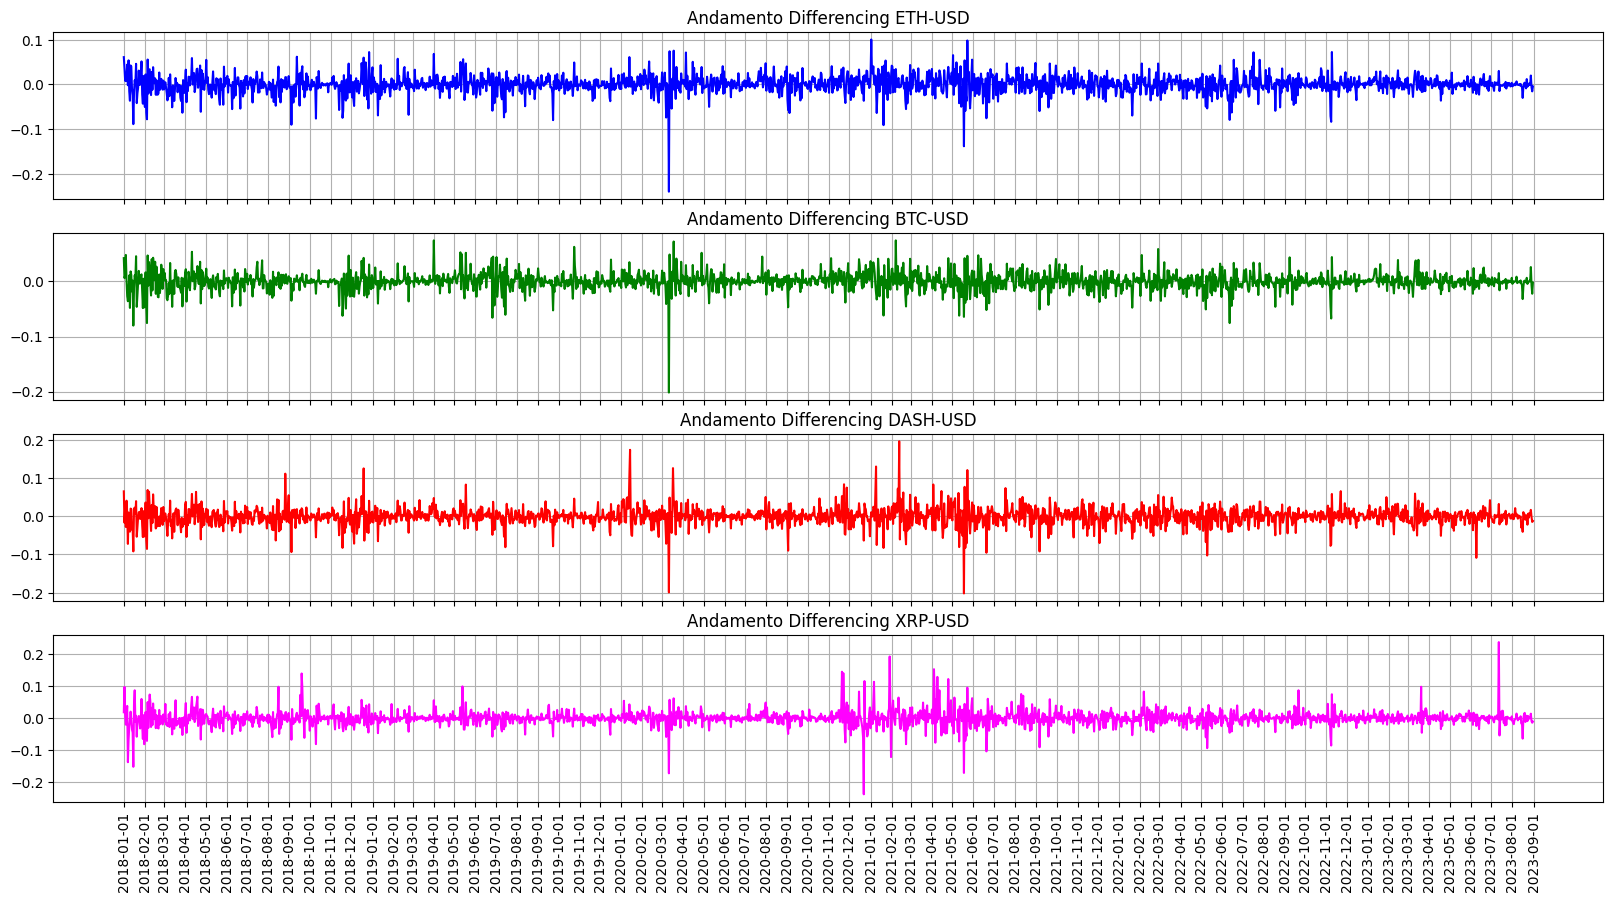

<Figure size 640x480 with 0 Axes>

In [110]:
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

### Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [111]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(differencingDict[crypto])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                      Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.23201574524870314 │    0.1 │ Accept  │
│ BTC-USD  │ 0.15674142996559834 │    0.1 │ Accept  │
│ DASH-USD │ 0.13769918829263092 │    0.1 │ Accept  │
│ XRP-USD  │ 0.19808342863898767 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                            Test Adfuller                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -13.748813873133491 │ 1.0600349812346666e-25 │ Reject  │
│ BTC-USD  │  -31.47046791687619 │                    0.0 │ Reject  │
│ DASH-USD │ -21.645263875919717 │                    0.0 │ Reject  │
│ XRP-USD  │  -46.79501030099321 │                    0.0 │ Reject  │
└──────────┴─────────────────────┴────────────────────────┴─────────┘

Dal test di KPSS e dal test ADF, possiamo concludere che il differencing $W_t$ è stazionario

### Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [112]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import kurtosis

In [113]:
# Crea il modello
SIGNIFICANCE_LEVEL = 0.05
bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
whiteTable = buildTable("White", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])

for crypto in cryptoList :
    x = sm.add_constant(differencingDict[crypto].index.tolist())
    model = sm.OLS(differencingDict[crypto].values, x)
    fittedModel = model.fit()
    print(crypto)
    print(fittedModel.summary())
    residKurtosis = kurtosis(fittedModel.resid)

    # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
    # In this case the F-statistic is preferable.

    # BREUSCH-PAGAN TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, residKurtosis > 0.05)

    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    # WHITE TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

ETH-USD
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5481
Date:                Sun, 12 Nov 2023   Prob (F-statistic):              0.459
Time:                        11:07:56   Log-Likelihood:                 5049.8
No. Observations:                2069   AIC:                        -1.010e+04
Df Residuals:                    2067   BIC:                        -1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.472 

In [114]:
console = Console()
console.print(bpTable)
console.print(whiteTable)

                        Test Breusch-Pagan                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  8.567367566736669 │ 0.0034597918568196914 │ Reject  │
│ BTC-USD  │  7.763759935805086 │  0.005379165131515243 │ Reject  │
│ DASH-USD │  2.276765009171112 │    0.1314783730532143 │ Accept  │
│ XRP-USD  │ 1.2467607341644058 │    0.2643018406639988 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

                            Test White                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   5.26508181913567 │ 0.005238555530471663 │ Reject  │
│ BTC-USD  │  4.141400487811925 │ 0.016032762971599328 │ Reject  │
│ DASH-USD │  3.666072606577798 │ 0.025743255972081297 │ Reject  │
│ XRP-USD  │ 0.7598677076192619 │   0.4678589731665155 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

### Analisi Autocorrelazione

Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box
* Durbin-Watson

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Per il test Durbin-Watson:
* $H_0$: Non c'è autocorrelazione di primo ordine nei residui del modello. In altre parole, l'autocorrelazione tra i residui ad uno e due intervalli di tempo di distanza è zero.
* $H_1$: C'è autocorrelazione di primo ordine nei residui del modello. I residui consecutivi sono correlati in qualche modo.

Vogliamo quindi :
* Ljung-Box, **Accettare**
* Durbin-Watson, **Accettare**

In [115]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [131]:
## TODO Capire perché accetta Ljung-Box

N_LAGS = 10
SIGNIFICANCE_LEVEL = 0.05
ljungTable = buildTable("Ljung-Box", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    testResult = acorr_ljungbox(differencingDict[crypto], lags = N_LAGS)
    statValue, pValue = testResult["lb_stat"][N_LAGS], testResult["lb_pvalue"][N_LAGS]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ljungTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

# N_LAGS = 10
# SIGNIFICANCE_LEVEL = 0.05
# ljungTable = buildTable("Ljung-Box", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
# for crypto in cryptoList :
#     residuals = (sm.tsa.ARIMA(endog=cryptoDataFrameDict[crypto]["LogClosePrice"],order=(0,0,0)).fit()).resid
#     testResult = acorr_ljungbox(residuals, lags = N_LAGS)
#     statValue, pValue = testResult["lb_stat"][N_LAGS], testResult["lb_pvalue"][N_LAGS]
#     outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
#     ljungTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

STATVALUE_LIMIT = 2
STAT_VALUE_MAX_DIF = 0.1

durbinWatsonTable = buildTable("Durbin-Watson", ["Crypto", "StatValue", "Outcome"], ["left", "right", "left"])
for crypto in cryptoList :
    data = differencingDict[crypto]
    x = sm.add_constant(data.index.tolist())
    model = sm.OLS(data.values, x)
    fittedModel = model.fit()
    statValue = durbin_watson(fittedModel.resid)
    outcomeString = "Accept" if (statValue > STATVALUE_LIMIT - STAT_VALUE_MAX_DIF) and (statValue < STATVALUE_LIMIT - STAT_VALUE_MAX_DIF) else "Reject"
    durbinWatsonTable.add_row(crypto, str(statValue), outcomeString)

console = Console()
console.print(ljungTable)
console.print(durbinWatsonTable)

                          Test Ljung-Box                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 31.609722534078987 │ 0.0004650065716092994 │ Reject  │
│ BTC-USD  │ 16.925034452734113 │   0.07603932218108504 │ Accept  │
│ DASH-USD │ 15.716773963771859 │   0.10803220218423684 │ Accept  │
│ XRP-USD  │  7.977674132723926 │     0.631017790629593 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

            Test Durbin-Watson             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 2.1061787086633696 │ Reject  │
│ BTC-USD  │  2.089375797391317 │ Reject  │
│ DASH-USD │  2.094945164179171 │ Reject  │
│ XRP-USD  │  2.059021802394454 │ Reject  │
└──────────┴────────────────────┴─────────┘

Tracciamo gli autocorrelogrammi e gli autocorrelogrammi parziali dei dati.

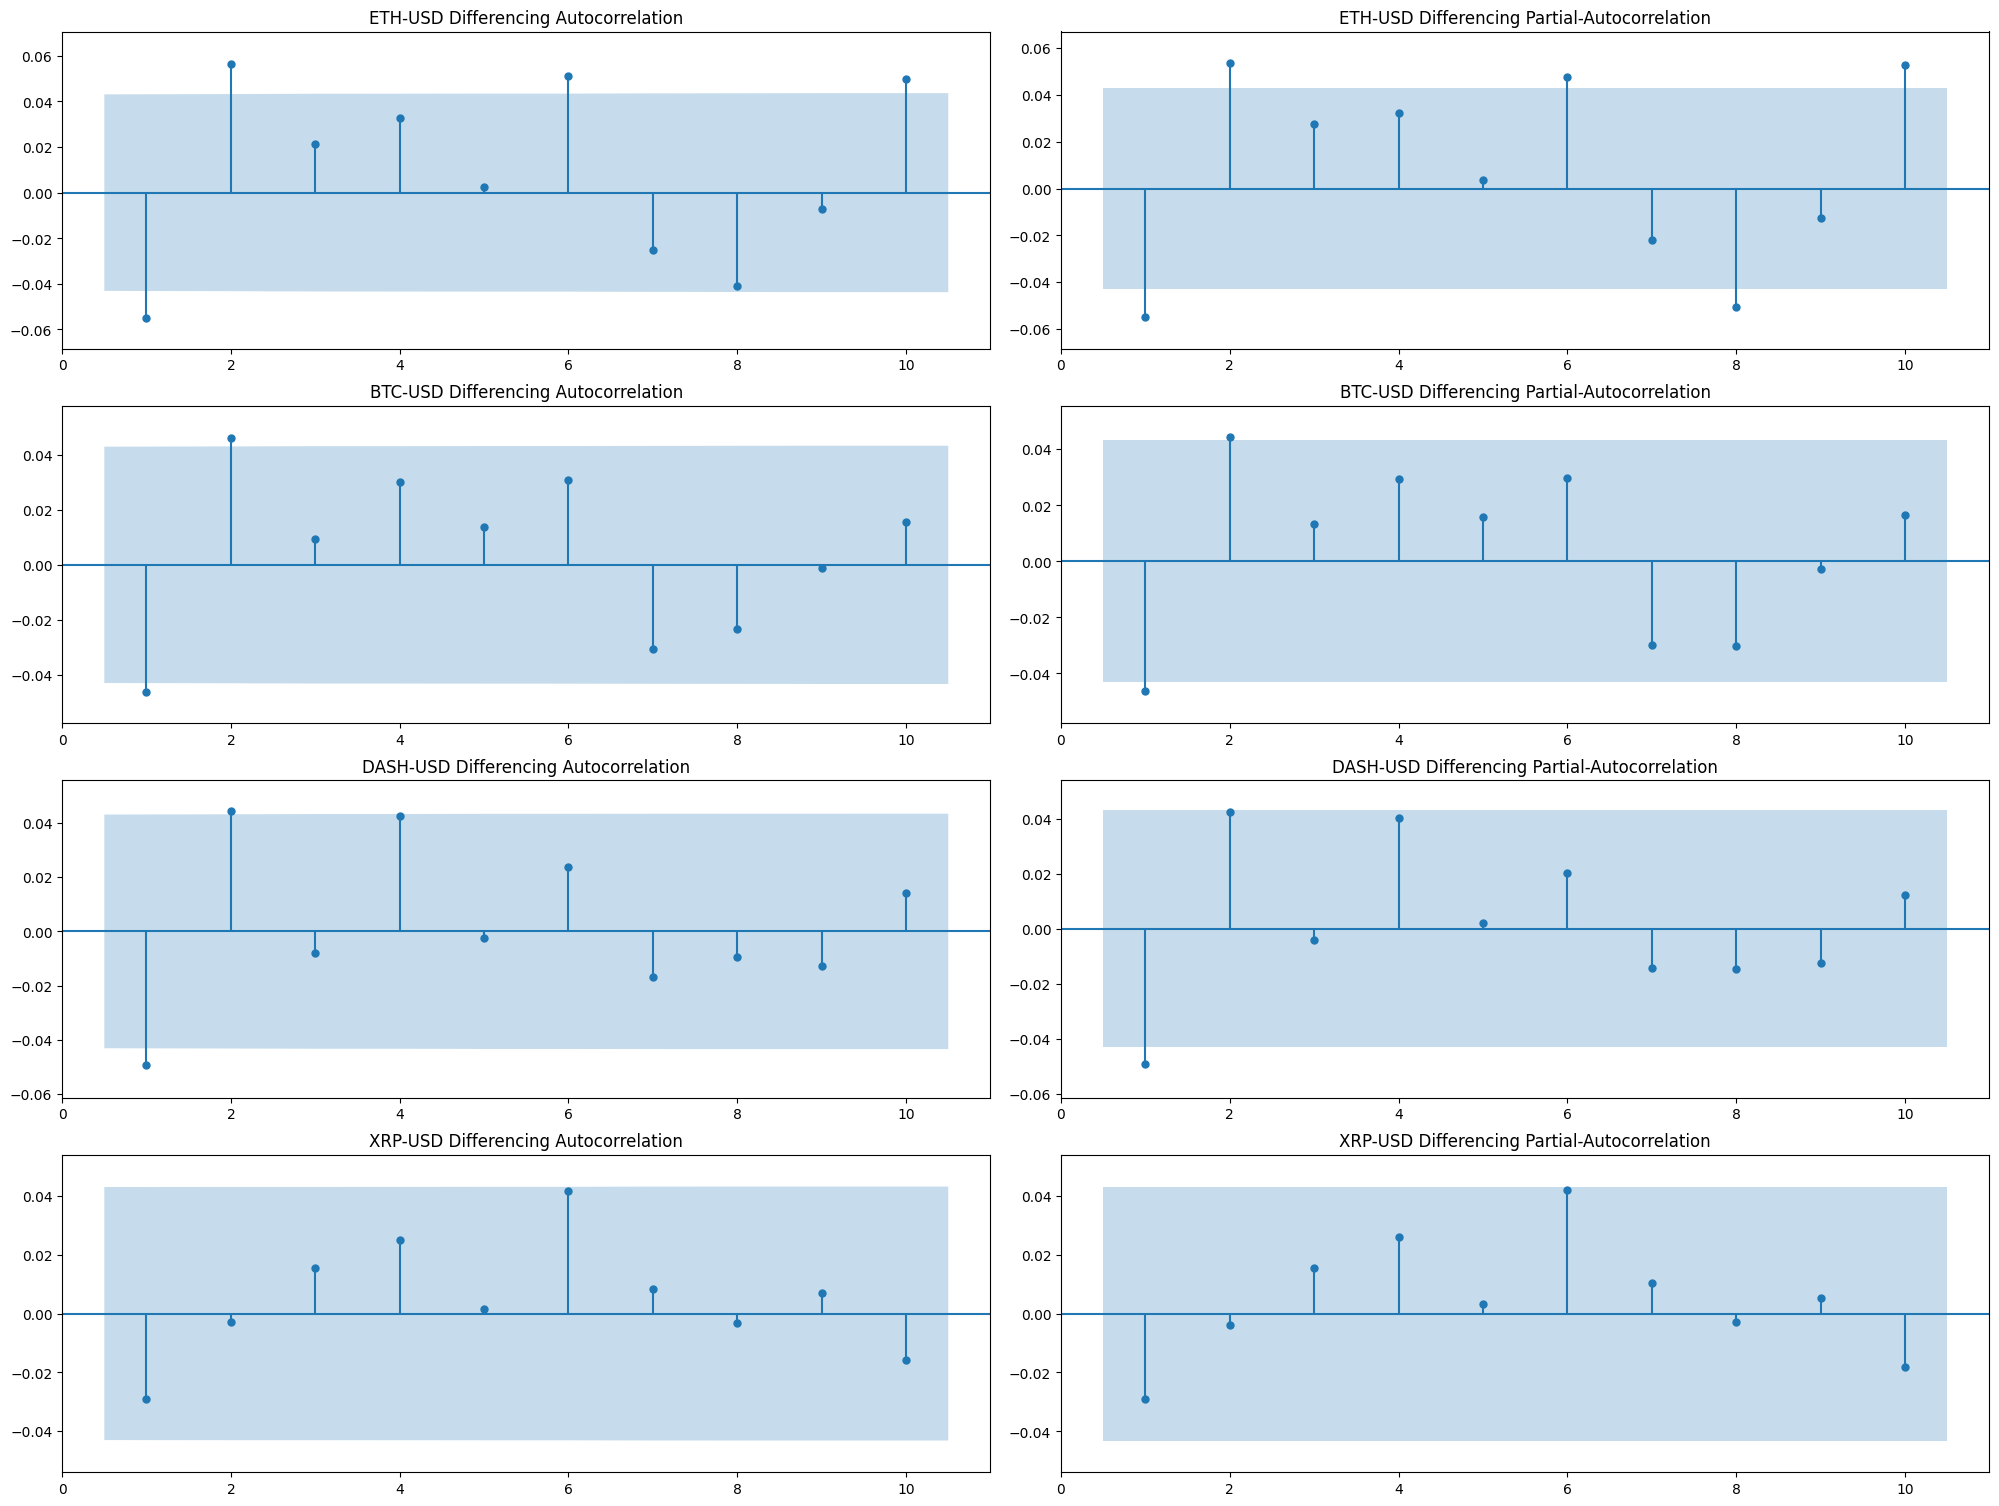

<Figure size 640x480 with 0 Axes>

In [132]:
N_LAGS = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
fig.tight_layout(h_pad = 2, w_pad = 2)
i = 0 
for crypto in cryptoList :
    axs[i].set_xticks(np.arange(0, N_LAGS, 1))
    axs[i].set_xticklabels(np.arange(0, N_LAGS, 1))
    plot_acf(x = differencingDict[crypto], ax = ax[i][0], lags = N_LAGS, title = crypto + " Differencing Autocorrelation", zero = False, auto_ylims = True)
    i += 1

i = 0 
for crypto in cryptoList :
    plot_pacf(x = differencingDict[crypto], ax = ax[i][1], lags = N_LAGS, title = crypto + " Differencing Partial-Autocorrelation", zero = False, auto_ylims = True)
    i += 1

plt.show()
plt.clf()

Stando a queste prove possiamo rigettare in entrambi i casi l'ipotesi nulla di assenza di autocorrelazione.

### Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* $H_0$: I dati seguono una distribuzione normale
* $H_1$: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* $H_0$: I dati seguono la distribuzione specificata
* $H_1$: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [118]:
#%%capture --no-display

from scipy.stats import shapiro, kstest, norm

SIGNIFICANCE_LEVEL = 0.05

# Esegue il test di normalità di Shapiro-Wilk
shapiroTable = buildTable("Shapiro-Wilk", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = shapiro(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(shapiroTable)

ksTable = buildTable("Kolmogorov-Smirnov", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = kstest(differencingDict[crypto], norm.cdf)
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(ksTable)


                         Test Shapiro-Wilk                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9225029349327087 │  2.243272511905845e-31 │ Reject  │
│ BTC-USD  │ 0.9065624475479126 │  7.687562699532387e-34 │ Reject  │
│ DASH-USD │ 0.9040272235870361 │ 3.3494620980164206e-34 │ Reject  │
│ XRP-USD  │ 0.8357081413269043 │   7.15923385423549e-42 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

               Test Kolmogorov-Smirnov               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  0.4705378122861261 │    0.0 │ Reject  │
│ BTC-USD  │ 0.47608764853183083 │    0.0 │ Reject  │
│ DASH-USD │ 0.46608875744466827 │    0.0 │ Reject  │
│ XRP-USD  │  0.4642030732172747 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

Notiamo quindi che i due test ci fanno rigettare in entrambi i casi l'ipotesi nulla di normalità dei dati.
Per completezza tracciamo un grafico dei dati.

Text(0.5, 1.0, 'Istogramma con normalizzazione tra 0 e 1')

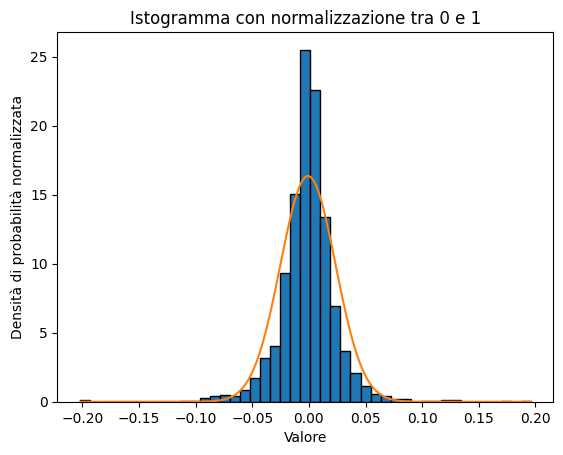

In [119]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
data = differencingDict["DASH-USD"]

counts, bins, _ = plt.hist(x = data, bins = int(np.sqrt(data.shape[0])), density = True, edgecolor = "black")

mean = np.mean(data)
stdDev = np.std(data)
x_array = np.linspace(bins.min(), bins.max(), 10000)
y_array = norm.pdf(x_array, loc = mean, scale = stdDev)
plt.plot(x_array, y_array, label = "Normal")

# Aggiunta di etichette e titoli
plt.xlabel('Valore')
plt.ylabel('Densità di probabilità normalizzata')
plt.title('Istogramma con normalizzazione tra 0 e 1')


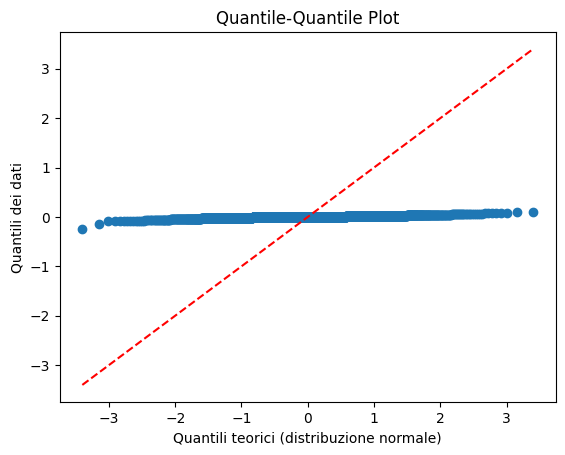

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Genera dati casuali
data = np.random.randn(100)

# Crea un qq-plot
quantiles, values = stats.probplot(differencingDict["ETH-USD"], fit=False, plot=None)
plt.scatter(quantiles, values)

# Aggiungi linea di riferimento per la distribuzione normale
plt.plot(quantiles, quantiles, linestyle='dashed', color='red')

# Aggiungi etichette e titolo
plt.title('Quantile-Quantile Plot')
plt.xlabel('Quantili teorici (distribuzione normale)')
plt.ylabel('Quantili dei dati')

# Mostra il grafico
plt.show()


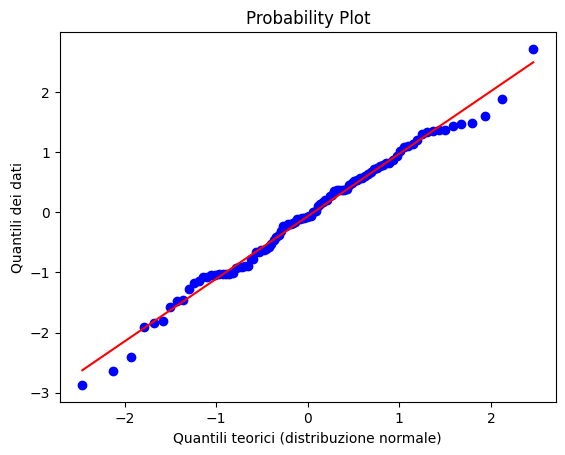

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Genera dati casuali
data = np.random.randn(100)

# Calcola i quantili teorici per una distribuzione normale
theoretical_quantiles = stats.probplot(data, plot=plt)

# Aggiungi etichette e titolo
plt.title('Probability Plot')
plt.xlabel('Quantili teorici (distribuzione normale)')
plt.ylabel('Quantili dei dati')

# Mostra il grafico
plt.show()
